# Deep Learning
---
data: https://archive.ics.uci.edu/dataset/850/raisin

### Load Data

Kecimen, Besni 건포도 품종의 이미지 데이터 900개

In [25]:
import pandas as pd

df = pd.read_excel('Raisin_Dataset.xlsx')

df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


### EDA - 보완 필요

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


null값이 없고, Class를 제외하고는 모두 numerical data이다. 추후 Class는 0,1로 변환해야 한다.

In [27]:
'''
|Area| : 지역,
|MajorAxisLength| : 주축길이,
|MinorAxisLength| : 단축길이,
|Eccentricity| : 이심률,
|ConvexArea| : 볼록한 면적,
|Extent| : 정도,
|Perimeter| : 둘레,
|Class| : 품종,
'''

'\n|Area| : 지역,\n|MajorAxisLength| : 주축길이,\n|MinorAxisLength| : 단축길이,\n|Eccentricity| : 이심률,\n|ConvexArea| : 볼록한 면적,\n|Extent| : 정도,\n|Perimeter| : 둘레,\n|Class| : 품종,\n'

In [28]:
df.shape

(900, 8)

### Data Preparation

In [29]:
X = df.drop('Class', axis=1)
y = df['Class']

print(X.shape, y.shape)

(900, 7) (900,)


In [30]:
import numpy as np

print(np.unique(y, return_counts=True))

(array(['Besni', 'Kecimen'], dtype=object), array([450, 450]))


각 class당 450, 450으로 동률이므로 skewed data가 아님을 알 수 있다.

Convert Target variable into numerical data

In [31]:
y = y.map({'Besni': 0, 'Kecimen':1})
print(y.shape)
print(y.head())
print(np.unique(y, return_counts=True))

(900,)
0    1
1    1
2    1
3    1
4    1
Name: Class, dtype: int64
(array([0, 1]), array([450, 450]))


Train, Test split

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Scaling

In [33]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

train_scaled = ss.fit_transform(X_train)
test_scaled = ss.transform(X_test)

print(train_scaled.shape, test_scaled.shape)

(720, 7) (180, 7)


validation set

In [34]:
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, y_train, random_state=42
)

## Construct DNN model

binary classification

In [35]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Dense(6, activation='relu', name='hidden', input_shape=(7,)))
model.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 6)                 48        
                                                                 
 output (Dense)              (None, 1)                 7         
                                                                 
Total params: 55 (220.00 Byte)
Trainable params: 55 (220.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 성능평가

- adam optimizer
- callback

In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best-model.keras', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=3)

history = model.fit(train_scaled, train_target, epochs=100, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, earlystopping_cb])

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [38]:
model = keras.models.load_model('best-model.keras')
model.evaluate(val_scaled, val_target)

6/6 [==============================] - 0s 3ms/step - loss: 0.3283 - accuracy: 0.8722


[0.32830530405044556, 0.8722222447395325]

In [39]:
earlystopping_cb.stopped_epoch

93

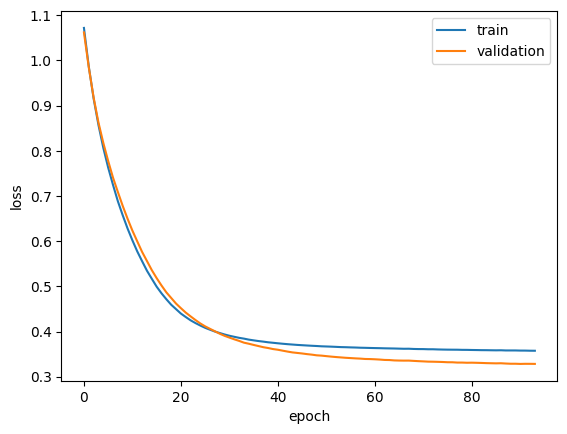

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()